In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad
from scipy.optimize import minimize

import numpy as np

import arviz as az

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="dark")

from src.likelihood import LogLikelihood
from src.velocity import velocity
from src.sampler_jax import hmc
from src.visualize.corner import corner

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_2043/4204090275.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


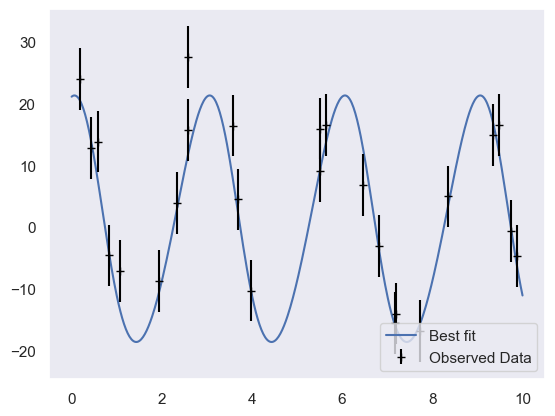

In [5]:
tf = 10
t = jnp.linspace(0, tf, 500)  # 500 time points over 10 days

# Orbital parameters
period = 3.0          # Orbital period in days
eccentricity = 0.08    # Moderate eccentricity (0 <= ecc < 1)
omega = 1.0          # Argument of periastron in radians 
phi0 = 1.0            # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# True Data
rv_true = velocity(t, period, eccentricity, omega, phi0, K, v0)

# Observed Data
n_observed = 25
time_obs = np.sort(np.random.uniform(0, tf, n_observed))
rv_err = 5
rv_obs = velocity(time_obs, period, eccentricity, omega, phi0, K, v0) + rv_err * np.random.normal(size=len(time_obs))


plt.plot(t, rv_true, label="Best fit")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.show()


In [6]:
loglikelihood = LogLikelihood(times=time_obs, 
                              observed_data=rv_obs, 
                              uncertainity=rv_err, 
                              jitter=0.0)

In [35]:
# Setup
starting_params = jnp.array(
    [3.1, 0.2, 1.2, 1.2, 22.0, 0.1]
    )

burn_in = 10**4
n_samples = 10**4

samples_burn_in, acceptance_rates = hmc(loglikelihood, 
                                starting_params, 
                                burn_in,
                                n_chains=16,
                                epsilon=0.0009, 
                                L=10, 
                                n_thin=1)
print(acceptance_rates)

samples, acceptance_rates = hmc(loglikelihood, 
                                samples_burn_in[-1,0,:], 
                                n_samples,
                                n_chains=16,
                                epsilon=0.0001, 
                                L=10, 
                                n_thin=1)
print(acceptance_rates)

[0.1677 0.2638 0.2108 0.2376 0.2443 0.1919 0.207  0.0767 0.1683 0.3431
 0.2109 0.0191 0.2461 0.2359 0.265  0.1964]
[0.     0.     0.     0.8835 0.8773 0.     0.     0.8663 0.862  0.
 0.8572 0.8855 0.8802 0.8756 0.8649 0.    ]


In [36]:
samples, acceptance_rates = hmc(loglikelihood, 
                                samples_burn_in[-1,0,:], 
                                n_samples,
                                n_chains=16,
                                epsilon=0.0001, 
                                L=20, 
                                n_thin=1)
print(acceptance_rates)

[0.     0.     0.     0.7417 0.724  0.     0.     0.7415 0.7205 0.
 0.7087 0.7264 0.7358 0.7276 0.6949 0.    ]


In [ ]:
acceptance_rates[]

Array([0.7087, 0.7264, 0.7358, 0.7276, 0.6949], dtype=float64)

In [45]:
samples[:, 10:-1, :].reshape(-1, 6).shape

(50000, 6)

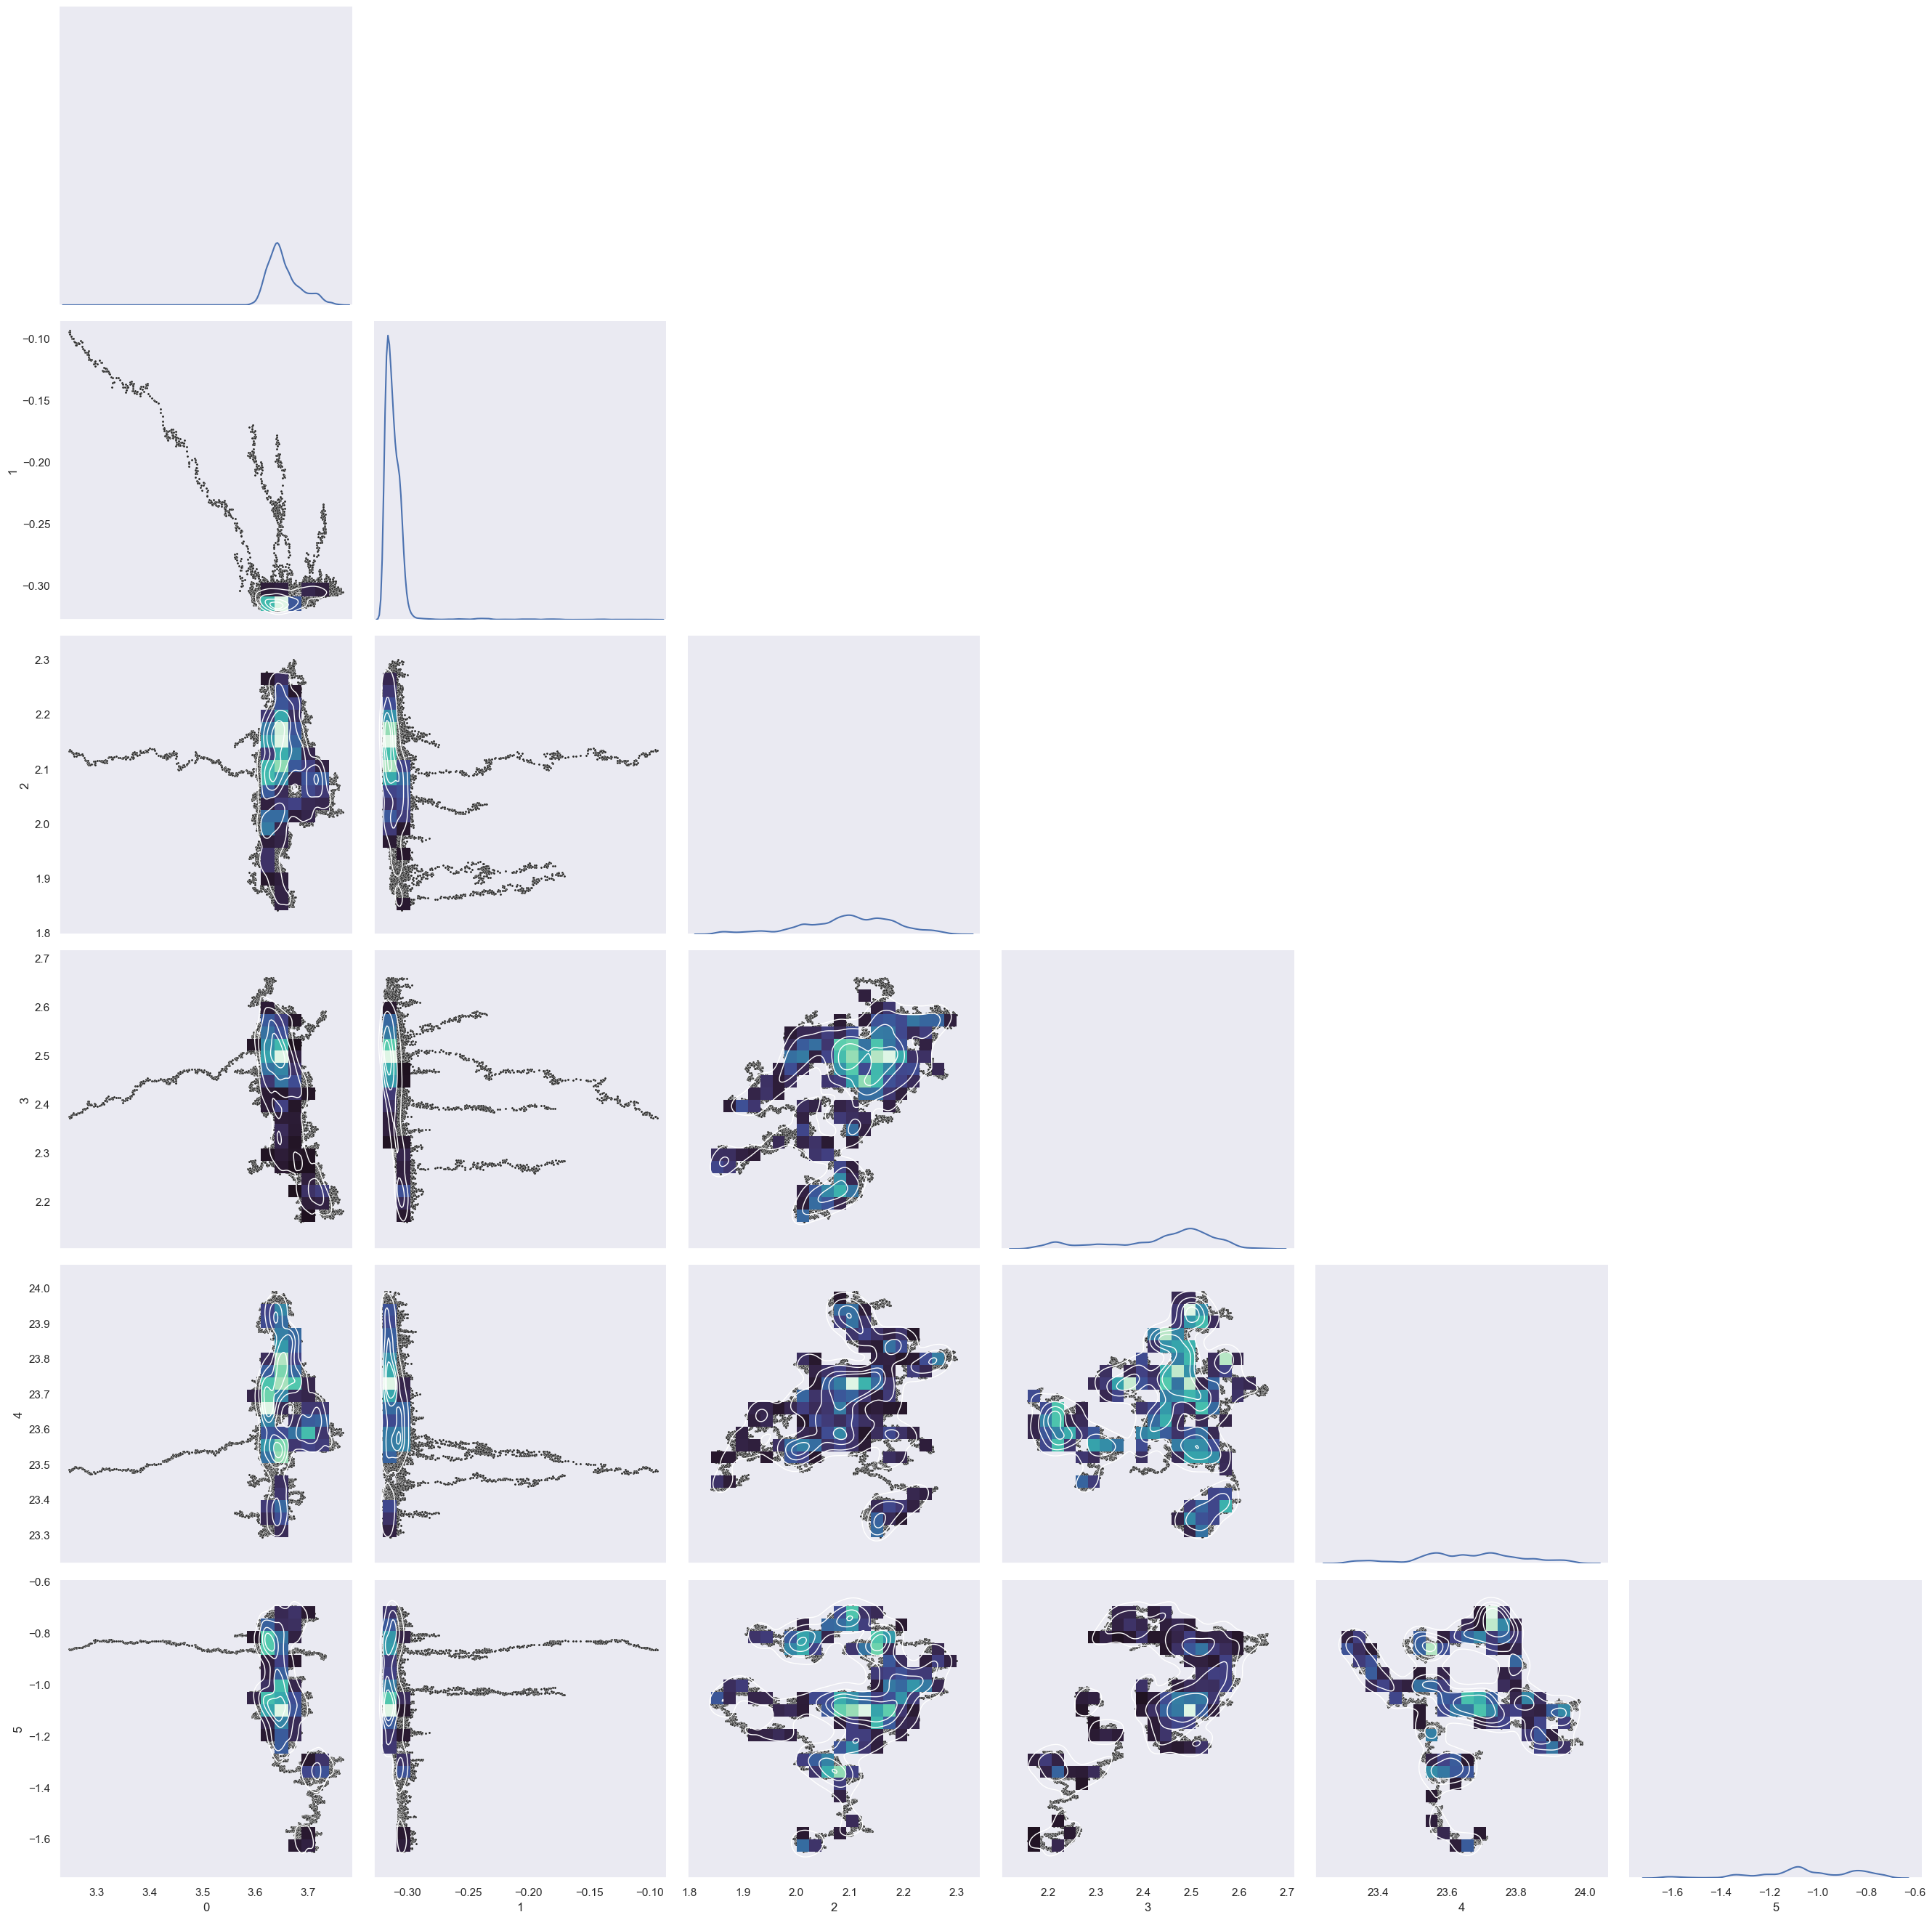

In [46]:
corner(samples[:, 10:-1, :].reshape(-1, 6))

### Autocorrelation

In [153]:
samples = np.asarray(samples)
param_names = [f"theta_{i}" for i in range(samples.shape[-1])]
coords = {"param": param_names}
dims   = {"theta": ["param"]}

idata = az.from_dict(
    posterior={"theta": samples},      # main group
    coords=coords, dims=dims)

# az.plot_autocorr(idata, var_names="theta");         # autocorrelation per chain
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[theta_0],2.980,0.030,2.925,3.032,0.005,0.004,32.0,65.0,1.10
theta[theta_1],0.093,0.051,0.001,0.195,0.007,0.004,46.0,169.0,1.07
theta[theta_2],0.650,0.254,0.228,1.150,0.104,0.057,7.0,13.0,1.64
theta[theta_3],1.350,0.262,0.867,1.795,0.113,0.053,6.0,48.0,1.92
theta[theta_4],21.797,0.234,21.383,22.271,0.101,0.060,6.0,14.0,1.96
theta[theta_5],0.298,0.542,-0.647,1.177,0.239,0.088,6.0,21.0,1.95


### Visualization

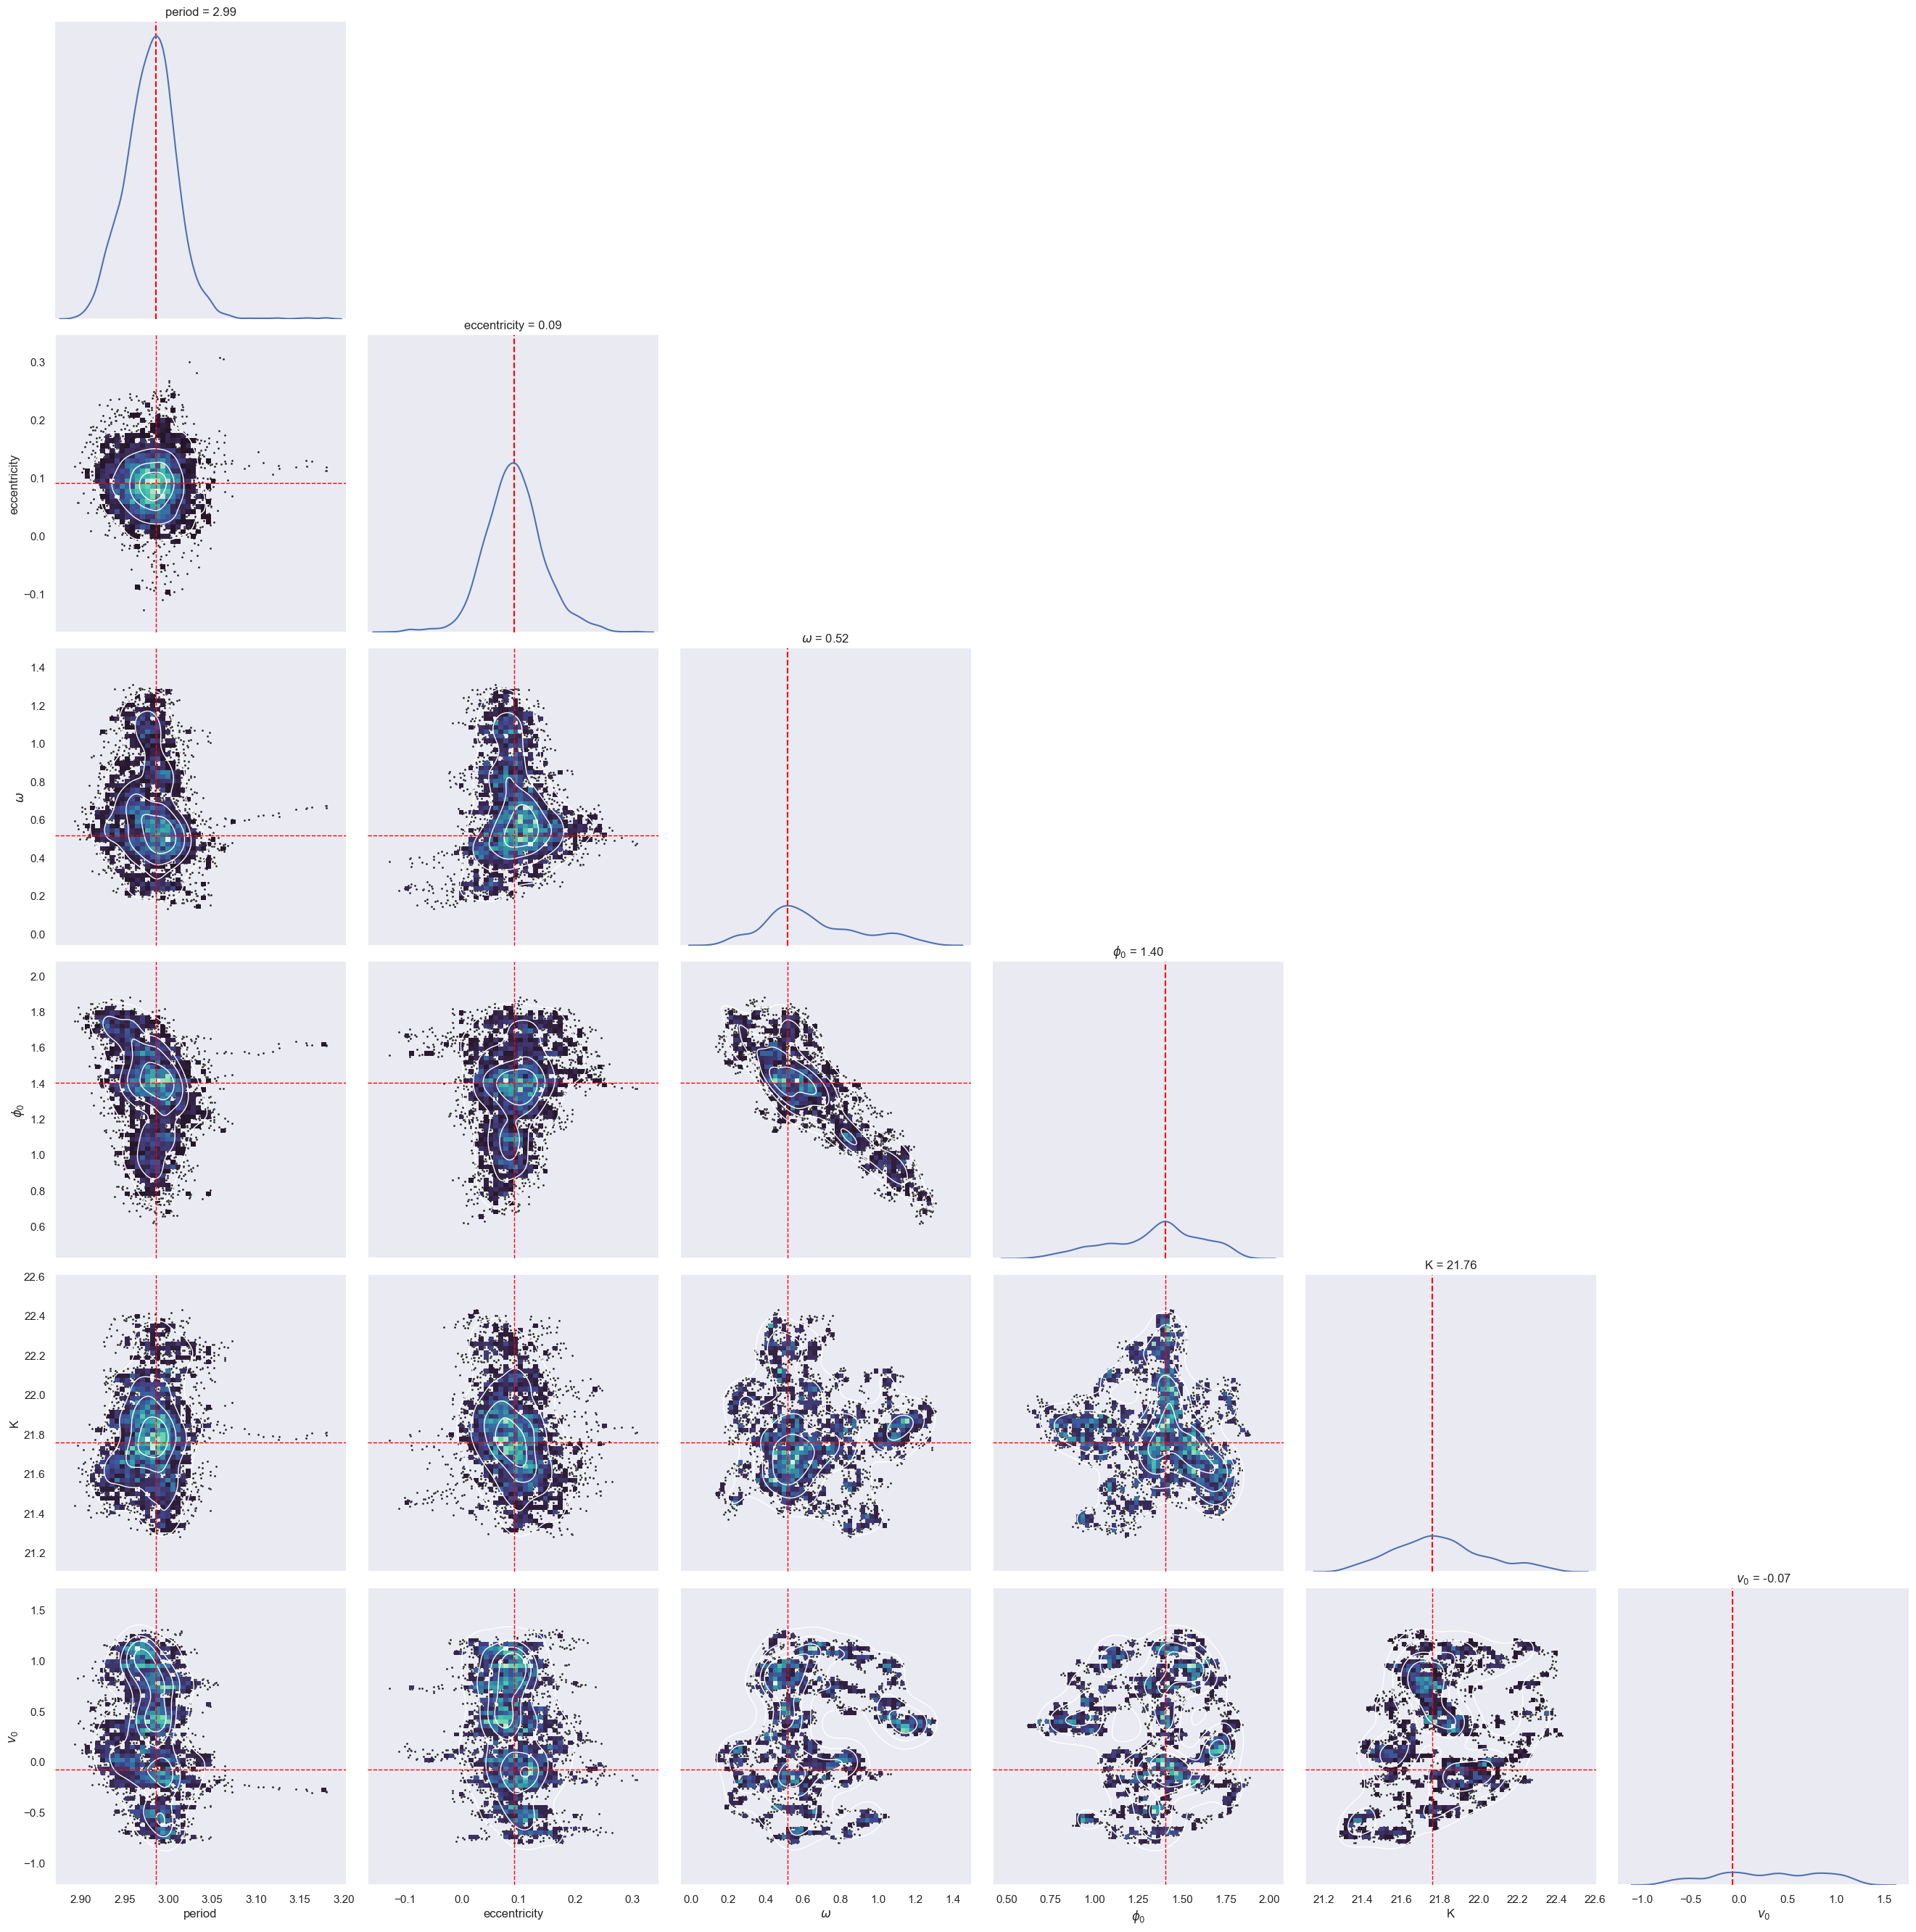

In [154]:
samples = samples.reshape(-1, 6)
labels = ["period", "eccentricity", "$\\omega$", "$\\phi_0$", "K", "$v_0$"]
corner(samples, labels=labels, show_titles=True, bins=50)